In [73]:
import os

import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 100
pd.options.mode.chained_assignment = 'raise'  # forbid chained assignment to prevent implicit errors

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 6)  # set default figure size
import math
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_validate
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

In [492]:
df = pd.read_csv('train.csv', index_col = 'Id')
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,3104.00000

In [493]:
def preproc(df):
    df.pop("Soil_Type7")
    df.pop("Soil_Type15") 
    #df['Mean_hillshade'] = df['Hillshade_Noon'] ** 2 - df['Hillshade_9am'] - df['Hillshade_3pm']**2
    df.pop("Hillshade_9am")
    df['Hillshade_Noon_sq'] = df['Hillshade_Noon'] ** 2
    df['Horizontal_Distance_To_Roadways_Log'] = [math.log(v+1) for v in df['Horizontal_Distance_To_Roadways']]
    
    df['Euclidian_Distance_To_Hydrology'] = (df['Horizontal_Distance_To_Hydrology']**2 + df['Vertical_Distance_To_Hydrology']**2)**0.5
    df['Elev_to_Horizontal_Hyd'] = df.Elevation - 0.2 * df.Horizontal_Distance_To_Hydrology 
    #df['Elev_to_Horizontal_Road'] = df.Elevation - 0.05 * df.Horizontal_Distance_To_Roadways  
    df['Elev_to_Horizontal_Road'] = (df.Elevation ** 2) * df.Horizontal_Distance_To_Roadways  

    df['Elev_to_Verticle_Hyd'] = df.Elevation - df.Vertical_Distance_To_Hydrology

    df['Mean_Horizontal_Dist'] = (df.Horizontal_Distance_To_Fire_Points + df.Horizontal_Distance_To_Hydrology + 
                                         df.Horizontal_Distance_To_Roadways)/3 
    df['Mean_Fire_Hydro'] = (df.Horizontal_Distance_To_Fire_Points + df.Horizontal_Distance_To_Hydrology)/2
    df['hydrology_lower'] = [1 if v <= 0 else 0 for v in df['Vertical_Distance_To_Hydrology']]
    #df['Aspect_sin_wild_1'] = [np.cos(v * np.pi/180) for v in df['Slope']] * df['Wilderness_Area1']
    
    return df

In [494]:
df = preproc(df)

In [484]:
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Mean_hillshade,Hillshade_Noon_sq,Horizontal_Distance_To_Roadways_Log,Euclidian_Distance_To_Hydrology,Elev_to_Horizontal_Hyd,Elev_to_Horizontal_Road,Elev_to_Verticle_Hyd,Mean_Horizontal_Dist,Mean_Fire_Hydro,hydrology_lower
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,31699,53824,6.236370,258.000000,2544.4,3437000160,2596,2349.000000,3268.5,1
2,2590,56,2,212,-6,390,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,32204,55225,5.968708,212.084889,2547.6,2616159000,2596,2275.666667,3218.5,1
3,2804,139,9,268,65,3180,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,38185,56644,8.064951,275.769832,2750.4,25002482880,2739,3189.666667,3194.5,0
4,2785,155,18,242,118,3090,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,41522,56644,8.036250,269.235956,2736.6,23966735250,2667,3181.000000,3226.5,0
5,2595,45,2,153,-1,391,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,32036,54756,5.971262,153.003268,2564.4,2633003775,2596,2238.666667,3162.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15116,2607,243,23,258,7,660,251,214,1282,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,17035,63001,6.493754,258.094944,2555.4,4485656340,2600,733.333333,770.0,0
15117,2603,121,19,633,195,618,221,91,1325,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,40311,48841,6.428105,662.354890,2476.4,4187326362,2408,858.666667,979.0,0
15118,2492,134,25,365,117,335,220,83,1187,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,41261,48400,5.817111,383.293621,2419.0,2080371440,2375,629.000000,776.0,0


In [42]:
crit = ['gini', 'entropy', 'log_loss']
acc, f_1 = [], []

for cr in crit:
    model = ExtraTreesClassifier(criterion=cr, random_state=42)
    scores = cross_validate(model,df.drop(columns="Cover_Type"),df["Cover_Type"],scoring=["accuracy", "f1_weighted", "roc_auc_ovr_weighted"],cv=10,n_jobs=-1)
    print(cr)
    print(f'Accuracy: {np.mean(scores["test_accuracy"])}')
    print(f'f1: {np.mean(scores["test_f1_weighted"])}')

gini
Accuracy: 0.8130291005291005
f1: 0.8103925006381761
entropy
Accuracy: 0.8160714285714284
f1: 0.8136808949345149
log_loss
Accuracy: nan
f1: nan


In [44]:
estim = [20, 50, 100, 250, 500]
acc, f_1 = [], []

for n in estim:
    model = ExtraTreesClassifier(criterion='entropy', n_estimators=n, random_state=42, n_jobs = -1)
    scores = cross_validate(model,df.drop(columns="Cover_Type"),df["Cover_Type"],scoring=["accuracy", "f1_weighted", "roc_auc_ovr_weighted"],cv=10,n_jobs=-1)
    acc.append(np.mean(scores["test_accuracy"]))
    f_1.append(np.mean(scores["test_f1_weighted"]))

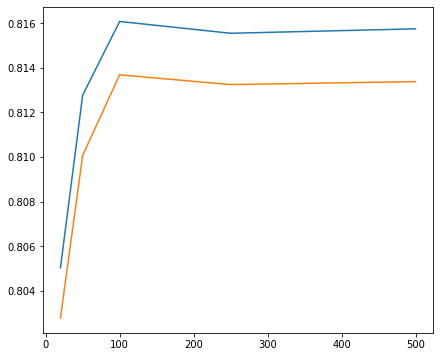

In [47]:
plt.plot(estim, acc)
plt.plot(estim, f_1)

In [50]:
weights = ['balanced', 'balanced_subsample']

for w in weights:
    model = ExtraTreesClassifier(criterion='entropy', class_weight=w, random_state=42, n_jobs = -1)
    scores = cross_validate(model,df.drop(columns="Cover_Type"),df["Cover_Type"],scoring=["accuracy", "f1_weighted", "roc_auc_ovr_weighted"],cv=10,n_jobs=-1)
    print(w)
    print(f'Accuracy: {np.mean(scores["test_accuracy"])}')
    print(f'f1: {np.mean(scores["test_f1_weighted"])}')

balanced
Accuracy: 0.8160714285714284
f1: 0.8136808949345149
balanced_subsample
Accuracy: 0.8160714285714284
f1: 0.8136808949345149


In [495]:
#model = RandomForestClassifier(n_jobs=-1, n_estimators = 200)

model = ExtraTreesClassifier(criterion='entropy', class_weight='balanced', random_state=42, n_jobs = -1)
scores = cross_validate(model,df.drop(columns="Cover_Type"),df["Cover_Type"],scoring=["accuracy", "f1_weighted", "roc_auc_ovr_weighted"],cv=10,n_jobs=-1)

In [496]:
print(f'Accuracy: {np.mean(scores["test_accuracy"])}')
print(f'f1: {np.mean(scores["test_f1_weighted"])}')
print(f'ROC AUC: {np.mean(scores["test_roc_auc_ovr_weighted"])}')

Accuracy: 0.8173280423280425
f1: 0.8149610231292425
ROC AUC: 0.9738782129792932


In [497]:
model.fit(df.drop(columns="Cover_Type"), df["Cover_Type"])

ExtraTreesClassifier(class_weight='balanced', criterion='entropy', n_jobs=-1,
                     random_state=42)

In [498]:
df_test = pd.read_csv('test.csv', index_col = 'Id')
df_test = preproc(df_test)

In [499]:
model_preds = model.predict(df_test)
model_preds

array([1, 1, 2, ..., 3, 3, 3], dtype=int64)

In [500]:


df_submission = pd.DataFrame({'Id' : df_test.index, 'Cover_Type': model_preds})
df_submission['Cover_Type'] = df_submission['Cover_Type'].astype(int)
df_submission.to_csv('submission.csv', index=False)

